<a href="https://colab.research.google.com/github/alondralezfra/AIML-Depression-Analysis/blob/main/RandomForestClassifierTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Data Preparation:***

* LabelEncoder() for Encoding categorical data
* First split the data into training and testing
* Second oversample minority class using SMOTE only on training data
* Third scale training and testing data


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

file_path = 'https://raw.githubusercontent.com/peilutu/AIML_HeartAttackPrediction/refs/heads/main/depression_data.csv'
depression_data = pd.read_csv(file_path)

# Data Cleaning and Encoding
columns_to_drop = ['Name']
depression_data_cleaned = depression_data.drop(columns=columns_to_drop, axis=1)

# Encode categorical columns
label_encoder = LabelEncoder()
categorical_columns = [
    'Marital Status',
    'Education Level',
    'Smoking Status',
    'Physical Activity Level',
    'Employment Status',
    'Alcohol Consumption',
    'Dietary Habits',
    'Sleep Patterns',
    'History of Mental Illness',
    'History of Substance Abuse',
    'Family History of Depression',
    'Chronic Medical Conditions',
]

for column in categorical_columns:
    depression_data_cleaned[column] = label_encoder.fit_transform(depression_data_cleaned[column])

# Define features and target
X = depression_data_cleaned.drop('History of Mental Illness', axis=1)
y = depression_data_cleaned['History of Mental Illness']

In [ ]:
from imblearn.over_sampling import SMOTE

# Split the scaled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Perform oversampling on the minority class on train data only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Key Changes:

* performed oversampling only on train data
* scaled after oversampling rather than before

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Train Accuracy: 0.7311061924364572
Test Accuracy: 0.6188878791980047
Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74     71986
           1       0.34      0.28      0.31     31456

    accuracy                           0.62    103442
   macro avg       0.53      0.52      0.52    103442
weighted avg       0.60      0.62      0.61    103442



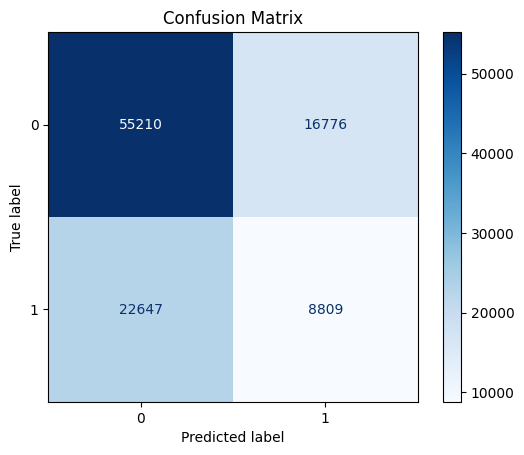

In [ ]:
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 8],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=30, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train_subset, y_train_subset)

# Get best model from random search
best_rf_model = random_search.best_estimator_

# Make predictions
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)

# Train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Classification report
print("Classification Report for Test Data:\n", classification_report(y_test, y_test_pred))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

Key changes:
* increased data from 10% to 30%
* increased iterations from 10 to 30
* increased folds from 3 to 5
* increased min_samples_split and min_samples_leaf values to reduce overfitting

***Resulting Hyperparameters***

RandomForestClassifier('bootstrap'=True,
'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False
)


In [ ]:
print(best_rf_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
# Creating Interaction Features for Selected Pairs

selected_pairs = [
    ("Age", "Physical Activity Level"),
    ("Physical Activity Level", "Dietary Habits"),
    ("Education Level", "Income"),
    ("Smoking Status", "Age"),
    ("Employment Status", "Income")
]

column_names = list(depression_data_cleaned.drop('History of Mental Illness', axis=1).columns)
X_train_manual_df = pd.DataFrame(X_train, columns=column_names)
X_test_manual_df = pd.DataFrame(X_test, columns=column_names)

for feature1, feature2 in selected_pairs:
    X_train_manual_df[f"{feature1}_x_{feature2}"] = X_train_manual_df[feature1] * X_train_manual_df[feature2]
    X_test_manual_df[f"{feature1}_x_{feature2}"] = X_test_manual_df[feature1] * X_test_manual_df[feature2]

X_train_manual = X_train_manual_df.values
X_test_manual = X_test_manual_df.values

Key Changes:
* added a new pair ("Employment Status", "Income")


=== Results for k=10 ===
Train Accuracy: 0.8283
Test Accuracy: 0.5890
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70     71986
           1       0.34      0.36      0.35     31456

    accuracy                           0.59    103442
   macro avg       0.52      0.53      0.52    103442
weighted avg       0.60      0.59      0.59    103442



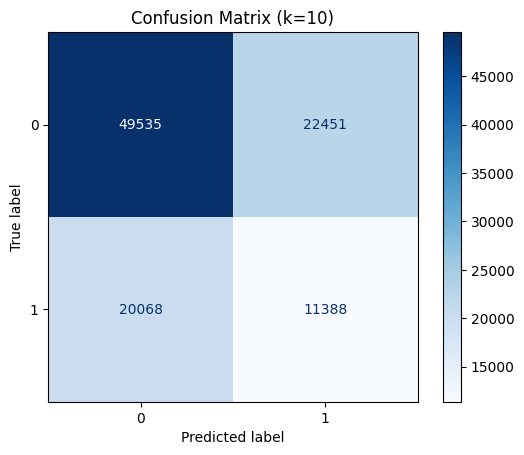


=== Results for k=11 ===
Train Accuracy: 0.8344
Test Accuracy: 0.5954
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71     71986
           1       0.34      0.34      0.34     31456

    accuracy                           0.60    103442
   macro avg       0.52      0.52      0.52    103442
weighted avg       0.60      0.60      0.60    103442



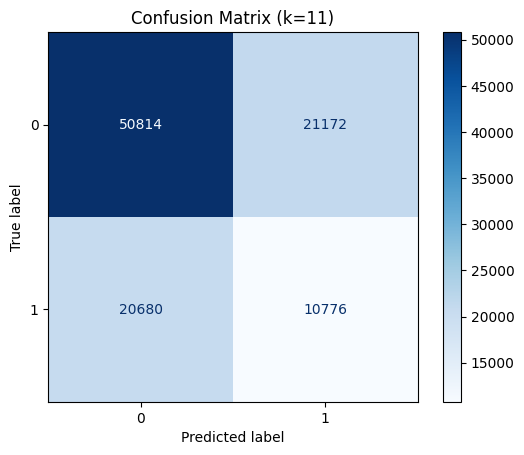


=== Results for k=12 ===
Train Accuracy: 0.8414
Test Accuracy: 0.6043
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72     71986
           1       0.34      0.32      0.33     31456

    accuracy                           0.60    103442
   macro avg       0.53      0.53      0.53    103442
weighted avg       0.60      0.60      0.60    103442



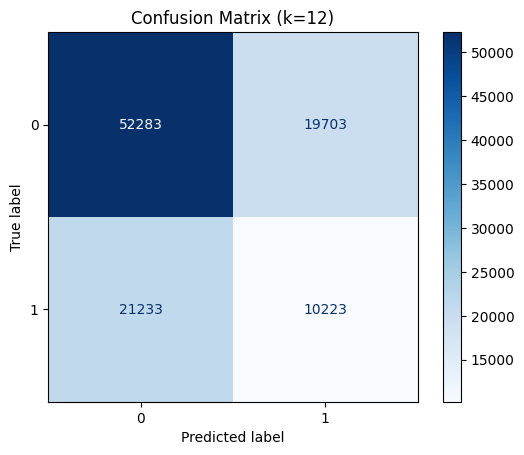


=== Results for k=13 ===
Train Accuracy: 0.8453
Test Accuracy: 0.6116
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73     71986
           1       0.34      0.30      0.32     31456

    accuracy                           0.61    103442
   macro avg       0.53      0.52      0.52    103442
weighted avg       0.60      0.61      0.60    103442



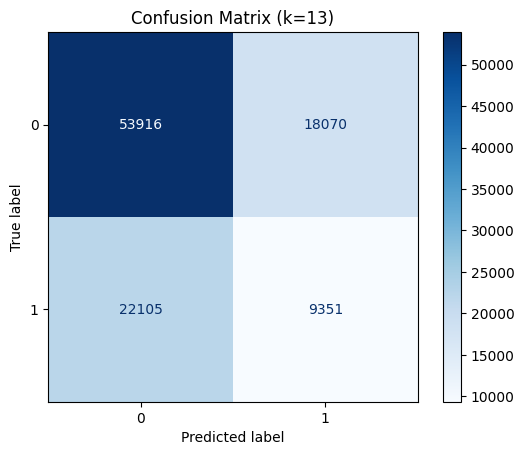

In [ ]:
# Feature Selection Using SelectKBest and Model Evaluation

from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Loop through different values of k
for k in range(10, 14):
    print(f"\n=== Results for k={k} ===")

    # Initialize and apply SelectKBest
    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_manual, y_train)
    X_test_selected = selector.transform(X_test_manual)

    # Train the Random Forest model on the selected features
    best_rf_model.fit(X_train_selected, y_train)
    y_train_pred_selected = best_rf_model.predict(X_train_selected)
    y_test_pred_selected = best_rf_model.predict(X_test_selected)

    # Evaluate performance
    train_accuracy_sel = accuracy_score(y_train, y_train_pred_selected)
    test_accuracy_sel = accuracy_score(y_test, y_test_pred_selected)

    print(f"Train Accuracy: {train_accuracy_sel:.4f}")
    print(f"Test Accuracy: {test_accuracy_sel:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_test_pred_selected))

    # Display the confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_selected, cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix (k={k})")
    plt.show()


Key Changes:
* tried k=10, 11, 12, and 13


=== Results for PCA(n_components=5) ===
Train Accuracy: 0.9075
Test Accuracy: 0.5984
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71     71986
           1       0.35      0.37      0.36     31456

    accuracy                           0.60    103442
   macro avg       0.53      0.53      0.53    103442
weighted avg       0.61      0.60      0.60    103442



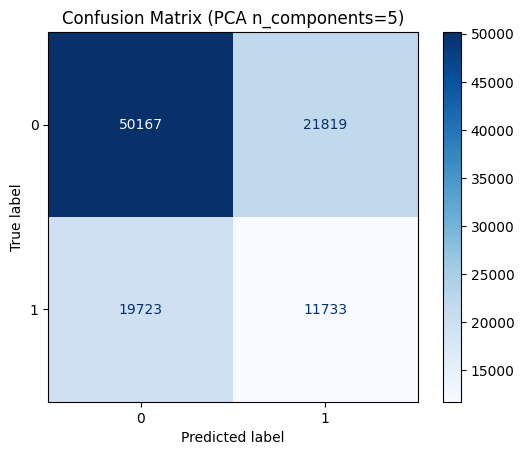


=== Results for PCA(n_components=6) ===
Train Accuracy: 0.9077
Test Accuracy: 0.6068
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72     71986
           1       0.34      0.32      0.33     31456

    accuracy                           0.61    103442
   macro avg       0.53      0.53      0.53    103442
weighted avg       0.60      0.61      0.60    103442



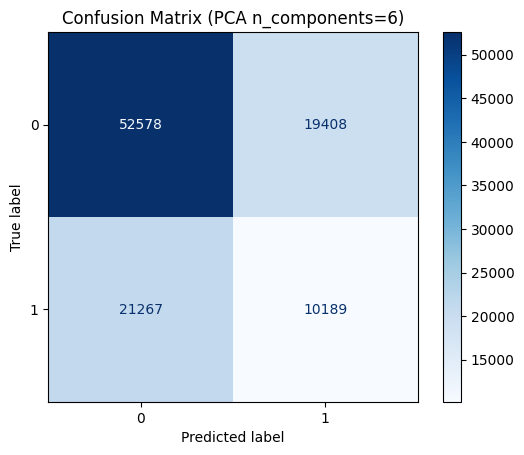


=== Results for PCA(n_components=7) ===
Train Accuracy: 0.9106
Test Accuracy: 0.6085
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72     71986
           1       0.34      0.32      0.33     31456

    accuracy                           0.61    103442
   macro avg       0.53      0.53      0.53    103442
weighted avg       0.60      0.61      0.60    103442



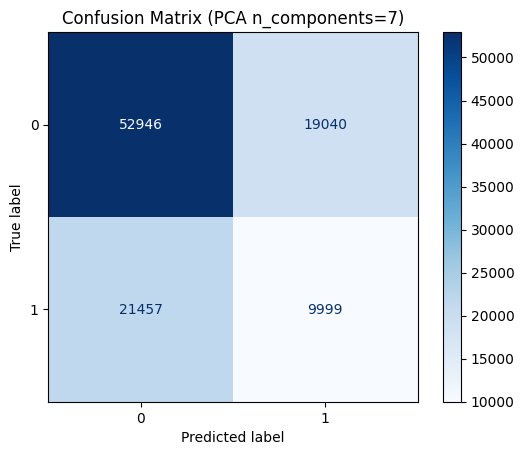


=== Results for PCA(n_components=8) ===
Train Accuracy: 0.9110
Test Accuracy: 0.6083
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72     71986
           1       0.34      0.31      0.33     31456

    accuracy                           0.61    103442
   macro avg       0.53      0.53      0.53    103442
weighted avg       0.60      0.61      0.60    103442



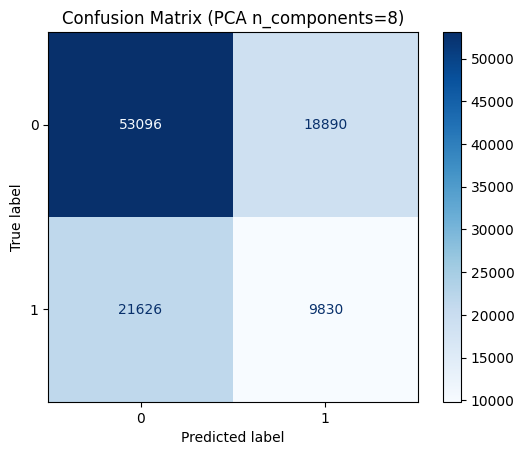

In [ ]:
# PCA for Dimensionality Reduction and Model Evaluation

from sklearn.decomposition import PCA

# Loop through different PCA components
for n_components in range(5, 9):
    print(f"\n=== Results for PCA(n_components={n_components}) ===")

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_manual_df)
    X_test_pca = pca.transform(X_test_manual_df)

    # Train the Random Forest model on PCA-transformed data
    best_rf_model.fit(X_train_pca, y_train)
    y_train_pred_pca = best_rf_model.predict(X_train_pca)
    y_test_pred_pca = best_rf_model.predict(X_test_pca)

    # Evaluate performance
    train_accuracy_pca = accuracy_score(y_train, y_train_pred_pca)
    test_accuracy_pca = accuracy_score(y_test, y_test_pred_pca)

    print(f"Train Accuracy: {train_accuracy_pca:.4f}")
    print(f"Test Accuracy: {test_accuracy_pca:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_test_pred_pca))

    # Display the confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_pca, cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix (PCA n_components={n_components})")
    plt.show()


Key Changes:
* tried components = 5, 6, 7, 8


=== Performance after PCA(components=5) and SelectKBest(k=10) ===
Train Accuracy: 0.8578
Test Accuracy: 0.5963
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71     71986
           1       0.34      0.34      0.34     31456

    accuracy                           0.60    103442
   macro avg       0.52      0.52      0.52    103442
weighted avg       0.60      0.60      0.60    103442



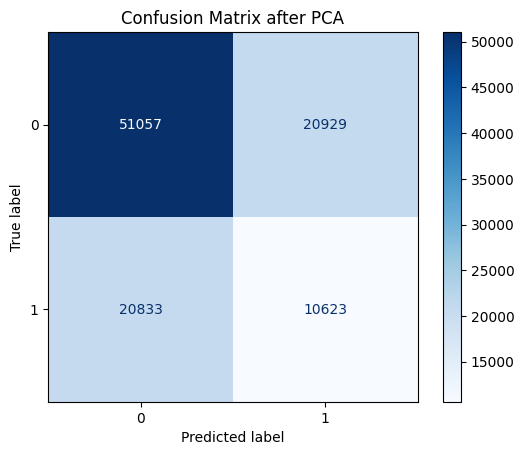

In [ ]:
# SelectKBest and PCA Combined

# Feature Selection with SelectKBest
selector = SelectKBest(mutual_info_classif, k=13)
X_train_selected = selector.fit_transform(X_train_manual, y_train)
X_test_selected = selector.transform(X_test_manual)

# Apply PCA to the manual feature DataFrame
pca = PCA(n_components=6)

X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

# Train the Random Forest model on the PCA-transformed data:
best_rf_model.fit(X_train_pca, y_train)
y_train_pred_pca = best_rf_model.predict(X_train_pca)
y_test_pred_pca = best_rf_model.predict(X_test_pca)

# Evaluate performance with PCA features:
train_accuracy_pca = accuracy_score(y_train, y_train_pred_pca)
test_accuracy_pca = accuracy_score(y_test, y_test_pred_pca)
print("\n=== Performance after PCA(components=5) and SelectKBest(k=10) ===")
print(f"Train Accuracy: {train_accuracy_pca:.4f}")
print(f"Test Accuracy: {test_accuracy_pca:.4f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred_pca))

# Display the confusion matrix:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_pca, cmap="Blues", values_format="d")
plt.title("Confusion Matrix after PCA")
plt.show()


***Conclusion***

I had originally performed oversampling using SMOTE on the entire dataset. I changed this to first split the dataset into training and testing and then afterwards performing oversampling only on the training data. This caused the model to decrease in performance, likely because there was data leakage with my original model. In my attempts to increase performance, I introduced new complexities, especially with the generated interaction features, which caused the model to overfit to the training data and overall did not improve the predictive ability of the model. The best model remains a simple RandomForestClassifier tuned using RandomSearch, with the data one-hot encoded, resampled for balance, and scaled. With test accuracy: 62% and train accuracy 73%.
